In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from axia import report
from axia import SBGSurvival

from importlib import reload

# Load Subscription Data

In [3]:
with open("./jobber_working_data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
data.df.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,frequency,country,industry
account_id,,,,,,,,,,
2,2011-04-01,NaT,95,1,65.0,128.0,128.0,monthly,canada,painting
34,2012-04-01,NaT,83,1,47.0,47.0,47.0,monthly,canada,arborist_/_tree_care
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,monthly,united_states,lawn_care_&_lawn_maintenance
109,2011-05-01,NaT,94,1,38.0,47.0,47.0,monthly,canada,painting
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,monthly,united_states,mechanical_service


# SBG

In [5]:
N_MONTHS = 12

In [6]:
dtr = data.dtr.join(data.features())
dva = data.dva.join(data.features())
sample_weight = np.exp(-(((dtr["start_date"].max() - dtr["start_date"]).dt.days / 30 + 1) ** 0.25) + 1)

In [7]:
features = [
    "country",
    "industry",
    "frequency",
    "month_one_retention_trend_s3",
    "month_one_retention_trend_s12"
]

sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=features,
    gamma=1e-3,
    verbose=False
)

In [8]:
%%time
sbg.fit(
    df=dtr,
#     sample_weight=sample_weight,
)

CPU times: user 1min 53s, sys: 1.36 s, total: 1min 54s
Wall time: 2min 1s


In [9]:
retention = sbg.predict_survival(dva, age=1, n_periods=N_MONTHS + 1)

In [10]:
def _expected_value_to_date(df):
    d = df.copy()
    d["expected_payment"] = d["probability"] * d["subscription_initial"]
    d["expected_value_to_date"] = (
        d
        .groupby(d.index.get_level_values("account_id"))
        .agg({"expected_payment": "cumsum"})
    )
    return d

In [11]:
(
    retention
    .join(data.dva[["start_date", "subscription_initial"]])
    .pipe(_expected_value_to_date)
    .reset_index("age")
    .query("age == {}".format(N_MONTHS - 1))
    .describe(percentiles=[0.1, 0.5, 0.9])
    .loc[["mean", "10%", "50%", "90%"]]
)

,age,probability,subscription_initial,expected_payment,expected_value_to_date
mean,11.0,0.699205,86.790623,59.450148,843.579828
10%,11.0,0.585407,39.000000,29.537721,407.368942
50%,11.0,0.685286,76.000000,50.112248,720.923619
90%,11.0,0.837169,145.000000,98.672691,1384.501443


In [12]:
cohort = (
    retention
    .join(data.dva[["start_date", "subscription_initial"]])
    .pipe(_expected_value_to_date)
    .reset_index("age")
    .query("age == {}".format(N_MONTHS - 1))
    .groupby("start_date")
    .agg({
        "age": "count",
        "probability": "mean",
        "subscription_initial": "mean",
        "expected_value_to_date": "mean",
    })
    .rename(columns={
        "age": "cohort_size",
        "probability": "expected_retention_rate",
        "subscription_initial": "mean_subscription_value_base",
    })
)

In [13]:
cohort.loc[:"2018-03-01"].tail(7)

,cohort_size,expected_retention_rate,mean_subscription_value_base,expected_value_to_date
start_date,,,,
2017-09-01,56,0.696625,104.482143,1016.015648
2017-10-01,61,0.684994,108.590164,1045.887149
2017-11-01,69,0.704044,108.927536,1073.847462
2017-12-01,49,0.681543,135.224490,1314.119988
2018-01-01,77,0.706623,125.766234,1235.376313
2018-02-01,72,0.681366,138.222222,1334.516975
2018-03-01,73,0.678774,137.753425,1323.613426


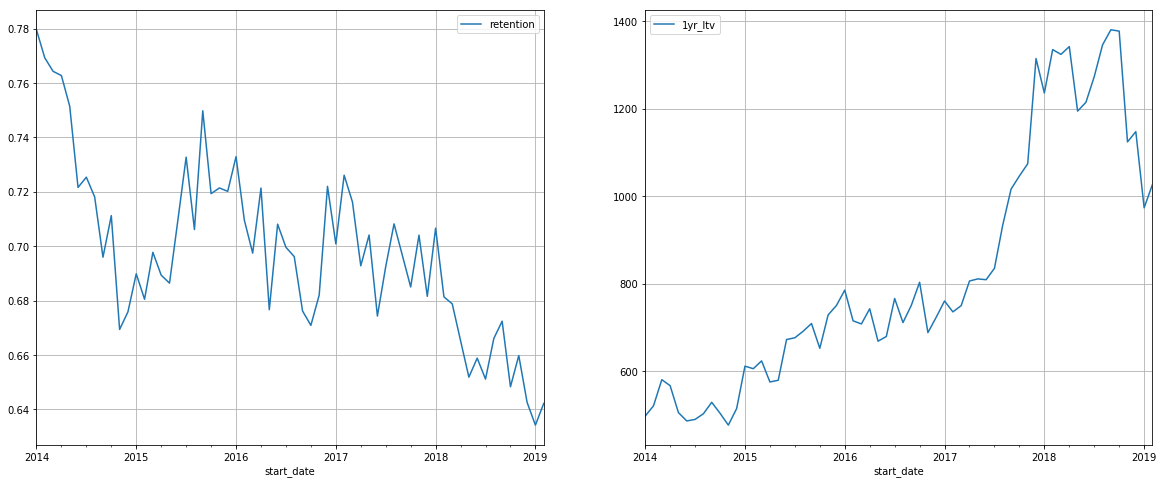

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

cohort.loc["2014-01-01":]["expected_retention_rate"].plot(ax=ax[0], label="retention")
cohort.loc["2014-01-01":]["expected_value_to_date"].plot(ax=ax[1], label="1yr_ltv")

for axis in ax:
    axis.grid(True)
    axis.legend()